# Machine learning applied to hyperspectral images

### Members:
* louis.guo
* raphael.ramelet
* ilan.guenet

Import python depedencies. Remember to run ```pip3 install -r requirements.txt``` before running the notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline

random_state = 32

## Load data

### hyperspectral image

In [2]:
!ls data/

indianapines_gt.npy  indianapines.npy  salinas_gt.npy  salinas.npy


In [3]:
X_indiana = np.load("data/indianapines.npy").astype('float32')
X_indiana.shape, X_indiana.dtype, np.min(X_indiana), np.max(X_indiana)

((145, 145, 200), dtype('float32'), 955.0, 9604.0)

In [4]:
def plot_rgb(im, title):
    rgb_bands = np.array([30, 15, 2])
    im_rgb = im[:,:,rgb_bands]

    pmin, pmax = np.percentile(im_rgb, (1,99), axis=(0,1))
    
    for i in range(pmin.size):
        # Normalize
        im_rgb[:,:,i] = (im_rgb[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])
        
    im_rgb[im_rgb<0] = 0
    im_rgb[im_rgb>1] = 1
    plt.axis("off")
    plt.title(title)
    plt.imshow(im_rgb)
    plt.plot()

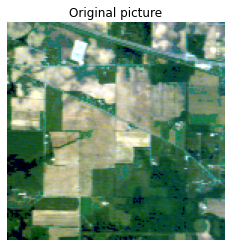

In [5]:
plot_rgb(X_indiana, "Original picture")

### Load labels

In [6]:
y_indiana = np.load("data/indianapines_gt.npy")
y_indiana.shape, y_indiana.dtype, np.min(y_indiana), np.max(y_indiana)

((145, 145), dtype('uint8'), 0, 16)

We can see there are 17 categories. Category 0 is considered as a non-category.

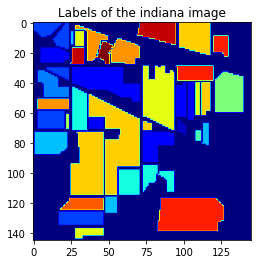

In [7]:
plt.imshow(y_indiana, cmap='jet')
plt.title("Labels of the indiana image")
plt.show()

## Dimension reduction


Machine learning is more efficient with lower dimensions. The hyperspectral image have 200 dimensions. That seems way too large for any machine learning algorithm. Thus, we are going to reduce the dimension of the problem using the **P**rincipal **C**omponents **A**nalysis (**PCA**) algorithm.

### Setup PCA

In [8]:
# The PCA requires a 2D matrix.
row, col, dim = X_indiana.shape
X_indiana = X_indiana.reshape((-1, dim))
X_indiana.shape

(21025, 200)

In [9]:
import sklearn.decomposition

pca = sk.decomposition.PCA(random_state=random_state)
pca

PCA(random_state=32)

In [10]:
pca.fit(X_indiana)

PCA(random_state=32)

### Analyse PCA

In [11]:
print(f"Number of components: {pca.n_components_} (equals to number of wavelength)")

Number of components: 200 (equals to number of wavelength)


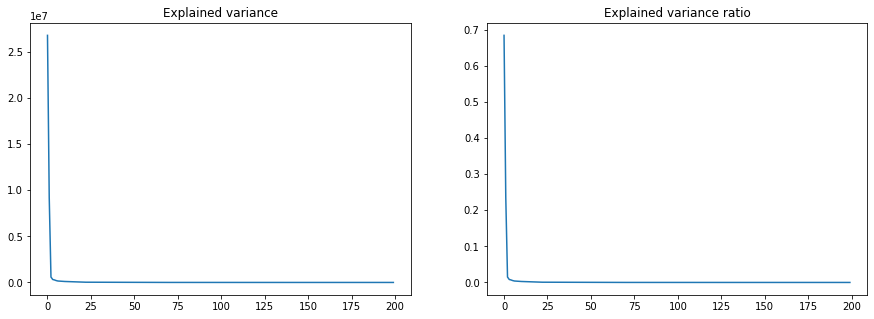

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_)
plt.title("Explained variance")

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio")
plt.show()

In [13]:
print(f"The first component explains {np.floor(pca.explained_variance_ratio_[0] * 100)}% of the variance")
print(f"The second component explains {np.floor(pca.explained_variance_ratio_[1] * 100)}% of the variance")

The first component explains 68.0% of the variance
The second component explains 23.0% of the variance


We can notice that the first components.

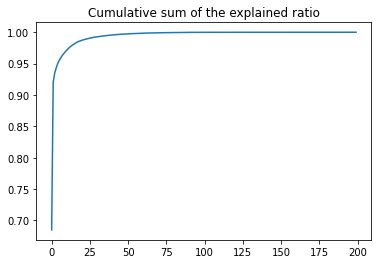

In [14]:
var_cumsum = pca.explained_variance_ratio_.cumsum()

plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

### Make decision

In [15]:
threshold = 0.95

# Number of selected eigen vectors where the cumulative sum of the explained 
# variance ratio of these eigen vectors is at least greater than the threshold 
nb_pc = np.where(var_cumsum>threshold)[0][0] + 1
print('%d explains at least %1.2f%% of the variance'%(nb_pc, threshold * 100))

5 explains at least 95.00% of the variance


In [16]:
## We need to fit again to use our new params 
pca_params = {"n_components" : nb_pc}
pca = pca.set_params(**pca_params)
pca.fit(X_indiana)

PCA(n_components=5, random_state=32)

In [17]:
Xproj = pca.transform(X_indiana).reshape((row,col,nb_pc))
Xproj.shape

(145, 145, 5)

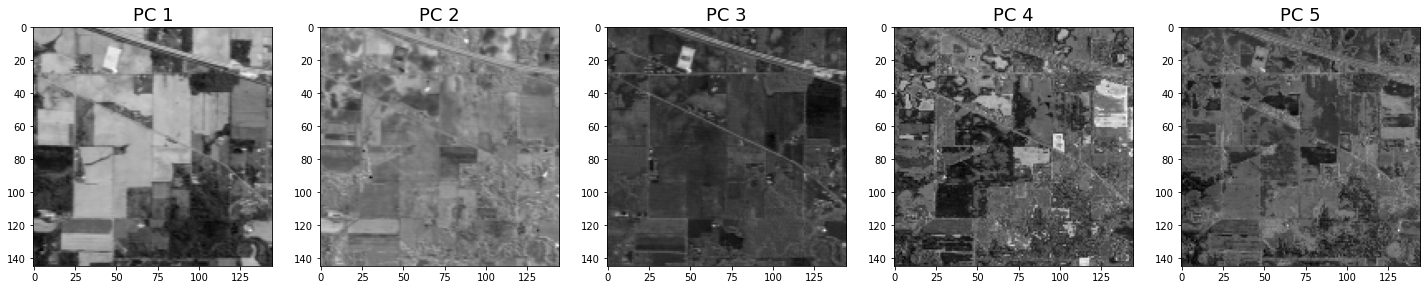

In [18]:
plt.figure(figsize=(30,15))
for i in range(nb_pc):
    plt.subplot(int(nb_pc / 6) + 1,6,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(Xproj[:,:,i],cmap='gray')
plt.show()

In [19]:
Xproj_back = pca.inverse_transform(Xproj) 

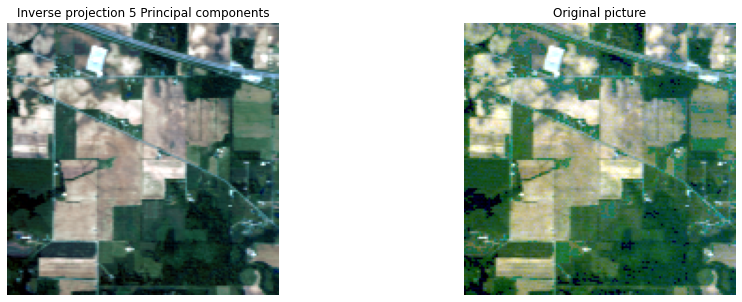

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_rgb(Xproj_back, "Inverse projection " + str(nb_pc) + " Principal components")
plt.subplot(1,2,2)
plot_rgb(X_indiana.reshape(row,col,dim), "Original picture")

### Extra information

In [21]:
def MSE(im1,im2):
    if im1.ndim > 2:
        im1 = im1.reshape((-1,im1.shape[2]))
    if im2.ndim > 2:
        im2 = im2.reshape((-1,im2.shape[2]))
    mse = ((im1-im2)**2).sum(axis=1).mean()
    return mse

In [22]:
MSE(Xproj_back, X_indiana)

1941170.2

In [23]:
nb_pc_range = np.unique(np.round(np.geomspace(1, 190, num=20))).astype(int)
nb_pc_range

array([  1,   2,   3,   4,   5,   7,   9,  12,  16,  21,  27,  36,  48,
        63,  83, 109, 144, 190])

In [24]:
mse_seq = []
for nb_pc_curr in nb_pc_range:
    pca_mse = sk.decomposition.PCA(n_components = nb_pc_curr, random_state = random_state)
    testproj = pca_mse.fit_transform(X_indiana)
    testproj_back = pca_mse.inverse_transform(testproj).reshape((row,col,dim))
    mse_seq.append(MSE(testproj_back, X_indiana))

mse_seq = np.array(mse_seq)

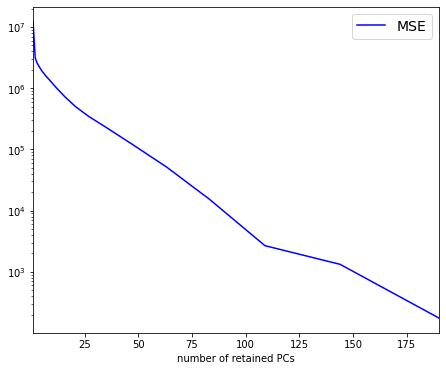

In [25]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(nb_pc_range, mse_seq, 'b', label='MSE')
plt.xlim(nb_pc_range[0], nb_pc_range[-1])
plt.xlabel('number of retained PCs')
plt.yscale('log')
plt.legend(loc='best', fontsize=14)
plt.show()